#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

252     3
3489    1
5042    5
9472    0
6918    3
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

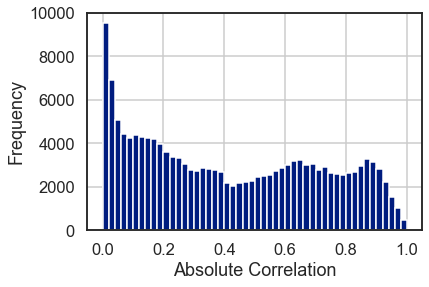

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[ -55.23199031,    7.31310026,   15.51105588, ...,  499.7733417 ,
        -210.60575771,  -39.40871094],
       [-215.26418551,  -98.10961094,   12.43317792, ...,  -63.18956924,
        -101.30485449,  -67.6061267 ],
       [  99.95963277,   76.49050694,   85.18771119, ..., -216.46314771,
         201.90138455,    8.79069902],
       [  -0.62843383,  -15.61065437,    7.39233285, ...,  -87.81980292,
          -4.63952278,   52.69677716],
       [ 101.04705985,   24.93058581,   -2.57295673, ..., -174.43009733,
         -17.53407719,   -4.94165803],
       [  70.11791704,    4.98607229, -117.9513211 , ...,   42.1292755 ,
         132.18282763,   50.46901949]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                               \
              0           1            2           3           4           5   
520  -67.561288   -5.240233  -110.769015   67.836834   71.368937   44.364765   
51    37.361117   67.951628    64.358212  -88.399696    8.786773  -90.058034   
237   27.946632   48.284586   -86.579926   33.973511   -5.584038  -18.040765   
57   486.067234  721.535162 -1023.342654 -141.645907 -183.738735  141.124900   
66    -6.928626   19.265446   -84.361758  -93.440627  164.217940    1.247625   
381  -22.249132   -4.376140    11.791653   -7.073948   97.881511  -75.973944   
282  -23.253549  -15.536756   -29.916611   65.646380   -9.304861   12.365398   
420   -4.703014   15.991973    30.311729  -34.422971   37.142023  -44.319740   
212   29.662451  -10.488638   -37.669661  -43.029072   13.653244   47.871675   
444  -52.094796  -69.338891    26.950563  -61.708425  158.847171   -2.655621   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
520  0.000000  0.000000  0.000000  0.000000  0.028238 -0.257598 -0.065802   
51   0.012902  0.000000  0.000000 -1.435360  0.000000 -2.305688  0.226801   
237  0.000000  0.000000  0.049956  0.000000 -0.087495  0.000000  0.055719   
57   0.386398  0.162531 -3.895359 -0.346809 -0.699182  1.280307  2.024136   
66   0.000000  0.000000  0.000000 -0.513405  0.894107  0.000000  0.003088   
381 -0.102833  0.000000  0.000000 -0.115540  0.828745 -1.201641 -0.020181   
282  0.000000  0.000000  0.000000 -0.046441  0.000000 -0.391968 -0.015508   
420  0.000000  0.000000  0.000000 -0.244980  0.479404  0.000000 -0.014743   
212  0.000000  0.000000 -0.115452 -1.783549  0.000000  1.653150  0.016687   
444  0.000000  0.000000  0.000000 -0.960177  0.976725  0.000000 -0.085181   

                                                       
            1         2         3         4         5  
520 -0.001240 -0.211413  0.061862  0.174020  0.042573  
51   0.265132 -0.262177 -0.221894  0.300371 -0.308233  
237  0.064243 -0.093733  0.167204 -0.051383 -0.142049  
57   1.019035 -3.009024 -0.412516 -0.575014  0.953383  
66  -0.086222 -0.164337 -0.346978  0.559870  0.034579  
381 -0.046269 -0.036198 -0.009660  0.564342 -0.452033  
282 -0.029329 -0.071845  0.140752 -0.025904  0.001833  
420 -0.014073 -0.007178 -0.132197  0.319132 -0.150941  
212  0.138143 -0.143022 -0.315207 -0.046956  0.350355  
444 -0.127191  0.035320 -0.282016  0.509310 -0.050241

Prepare six separate plots for each of the multi-class coefficients.

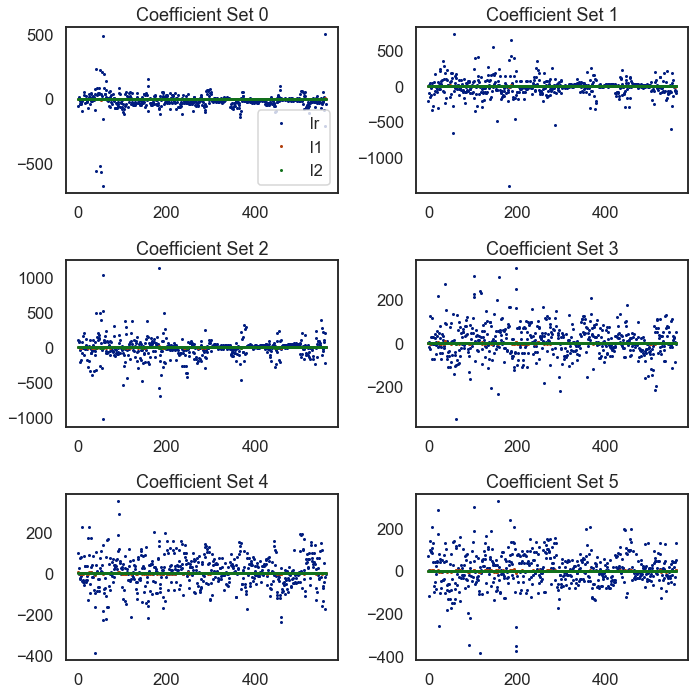

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [22]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998952,0.999998
1,1.0,0.999390,0.999653
2,1.0,0.995624,0.998870
3,1.0,0.999201,0.997828
4,1.0,0.999915,0.999302


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [25]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.982179,0.983835,0.983485
recall,0.982201,0.983819,0.983495
fscore,0.982188,0.983815,0.983488
accuracy,0.982201,0.983819,0.983495
auc,0.989214,0.990144,0.989983


## Question 8

Display or plot the confusion matrix for each model.

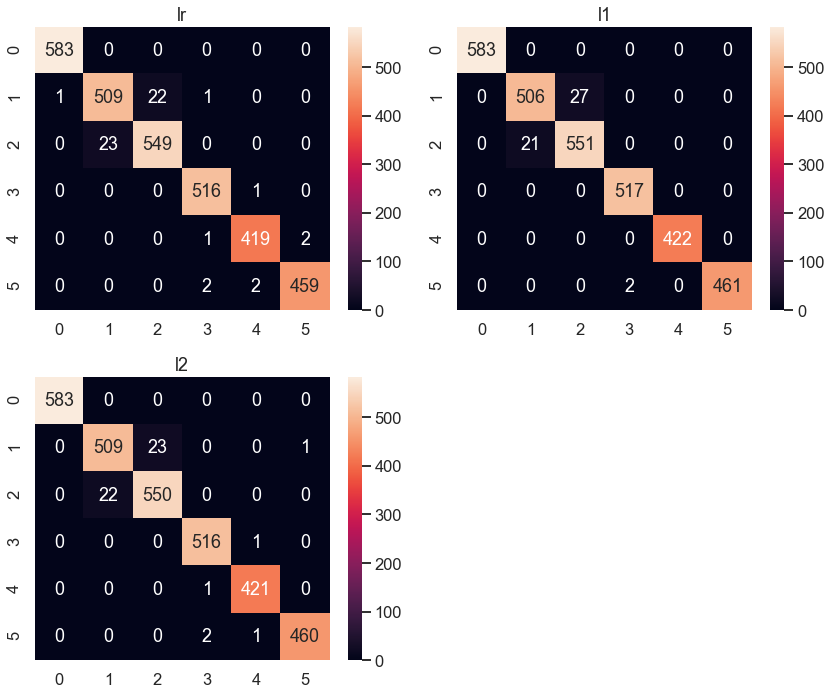

In [26]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Question 9
 Identify highly correlated columns and drop those columns before building models

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


 Repeat Model building with new training data after removing higly correlated columns

In [28]:
# Try standard, L1 and L2 Logistic regression
my_lr = LogisticRegression(max_iter=10000, penalty='none').fit(X_train_new, y_train_new)
my_lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train_new, y_train_new)
my_lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

In [29]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [41]:
coefficients = list()

labels = ['lr', 'l1', 'l2']
models = [lr, lr_l1, lr_l2]

for lab,mod in zip(labels, models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                                \
             0            1            2           3           4           5   
96  -26.779278   -10.975774    12.884178   48.589554   -1.221830  -22.496850   
421 -13.669045    16.273436    14.000503  -15.788443   43.606312  -44.422763   
20  -25.522509   -46.864852   -11.287748   58.010975  -14.571130   40.235264   
18   21.444673    -3.051676   119.851625   -6.641366  -44.983469  -86.619787   
373  57.422841    54.435424   -60.758256   32.625817  -23.095963  -60.629862   
153  42.299590   -43.608850   122.747002  -27.605530 -144.707066   50.874855   
82    8.286325  -242.491856   298.394607   33.866658  -17.311639  -80.744096   
162   7.455205   141.548476  -132.331939   49.749248   38.010167 -104.431157   
182 -73.972845 -1389.546012  1135.298759  168.576343  133.054044   26.589712   
181 -44.916248   -81.038117    37.413720   74.241001   70.144306  -55.844662   

      l1                                                            l2  \
       0          1          2         3         4         5         0   
96   0.0   0.000000   0.000000  0.000000  0.000000 -0.458665 -0.023321   
421  0.0   0.000000   0.000000 -0.160387  0.255161 -0.090425 -0.022001   
20   0.0   0.000000   0.000000  0.026898  0.000000 -0.606872 -0.013683   
18   0.0   0.000000   0.000000  0.000000  0.000000 -0.103730  0.066377   
373  0.0  -1.148162   0.219105  0.931066  0.000000 -0.849528  0.036574   
153  0.0   0.000000   0.000000 -0.182697 -1.337615  1.789402  0.087378   
82   0.0  -1.190517   1.351693 -0.051523  0.000000 -0.048550  0.041438   
162  0.0   0.000000   0.000000  0.941249  0.000000 -0.564297  0.009525   
182  0.0 -14.963574  15.207864  1.208121  0.488083 -0.944663 -0.096140   
181  0.0   0.000000   0.000000  0.953468  0.562556 -1.328938 -0.050643   

                                                       
            1         2         3         4         5  
96  -0.043074 -0.014602  0.146926 -0.001273 -0.064657  
421 -0.009914 -0.035182 -0.083546  0.285927 -0.135284  
20  -0.039109 -0.006137  0.093384 -0.190833  0.156378  
18  -0.120320  0.320917  0.003763 -0.079515 -0.191222  
373 -0.318199  0.380685  0.262493  0.021915 -0.383467  
153 -0.097771  0.240613 -0.270226 -0.391392  0.431398  
82  -0.584629  0.610276  0.092808  0.049365 -0.209258  
162  0.372518 -0.381219  0.240632  0.113225 -0.354682  
182 -5.339277  5.088572  0.478123  0.200025 -0.331301  
181 -0.175475  0.029413  0.358727  0.280900 -0.442922

Prepare six separate plots for each of the multi-class coefficients.

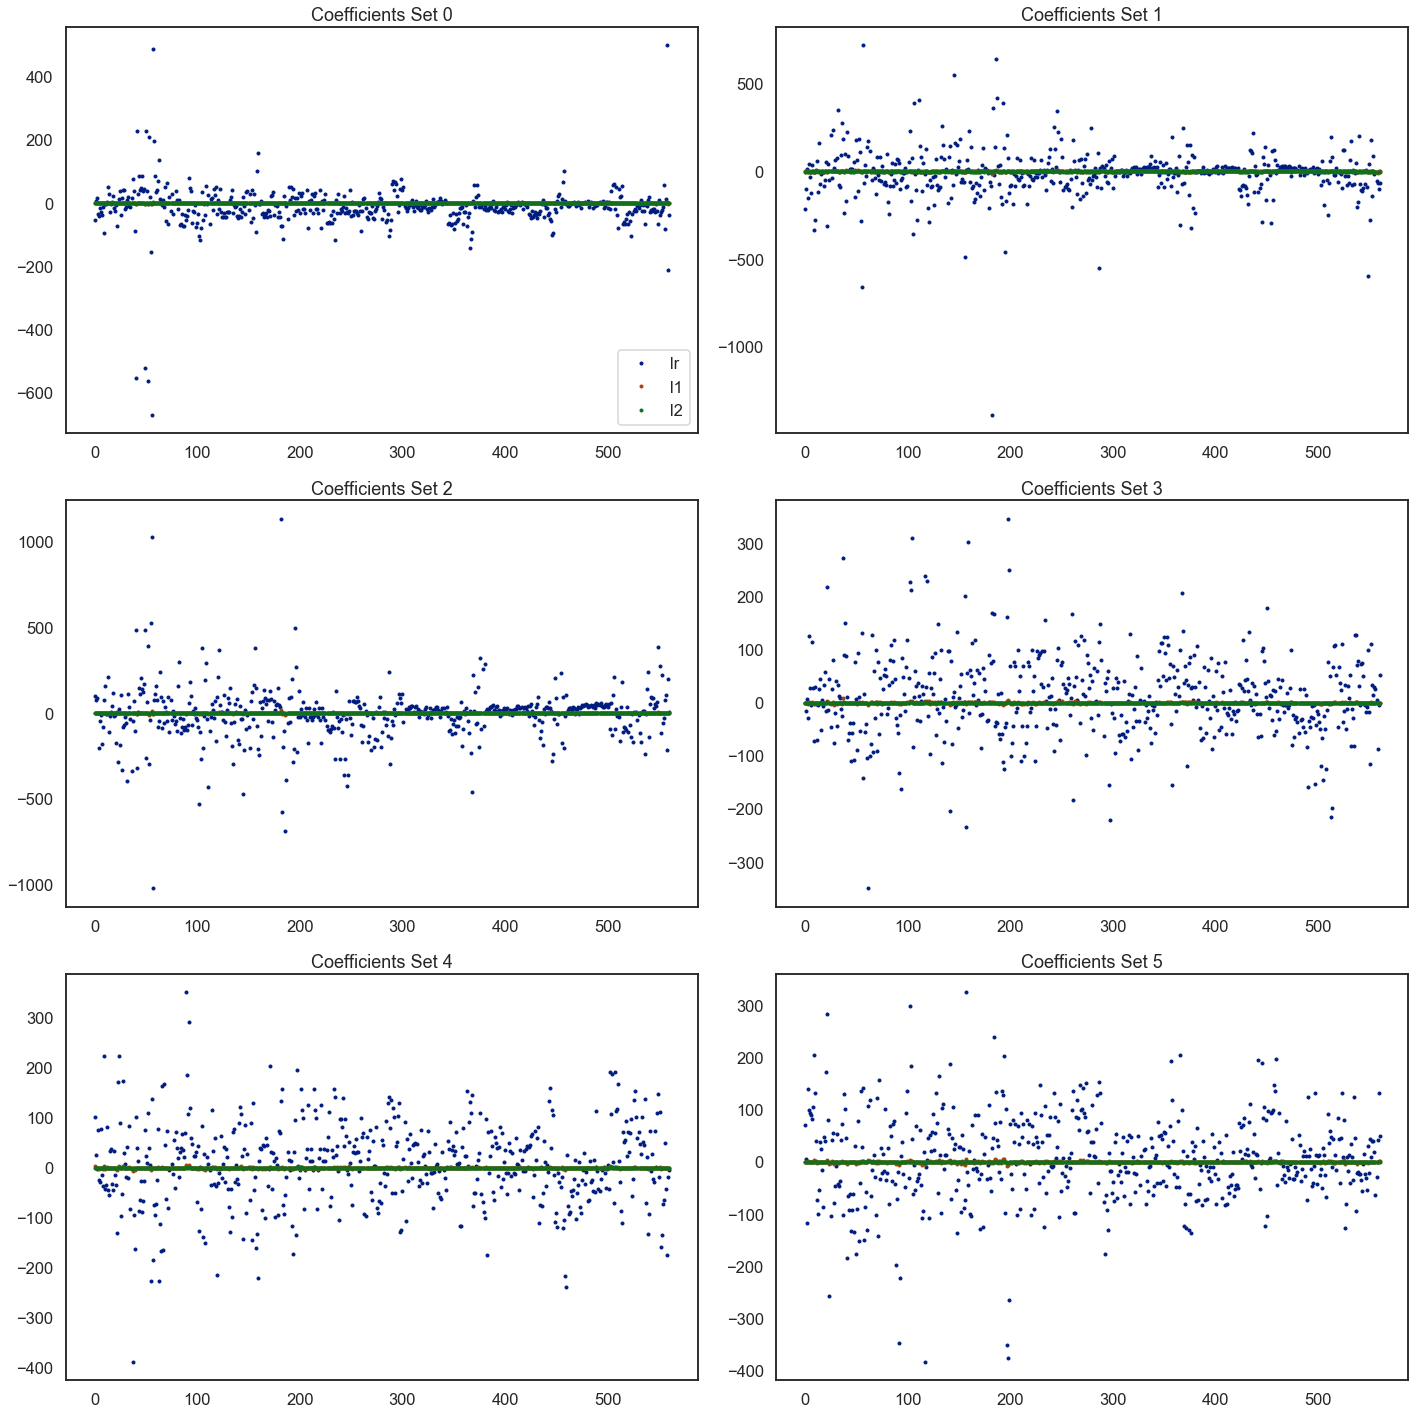

In [47]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(20,20)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=3.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficients Set '+ str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [60]:
# Predict the class and the probability for each
new_y_pred = list()
new_y_prob = list()

labels = ['lr', 'l1', 'l2']
models = [my_lr, my_lr_l1, my_lr_l2]

for lab,mod in zip(labels, models):
    new_y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    new_y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
new_y_pred = pd.concat(new_y_pred, axis=1)
new_y_prob = pd.concat(new_y_prob, axis=1)

new_y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [61]:
# Calculate the error metrics as listed above
metrics_new = list()
cm = dict()

for lab in coeff_labels:

    precision, recall, fscore, _ = score(y_test_new, new_y_pred[lab], average='weighted')
    accuracy = accuracy_score(y_test_new, new_y_pred[lab])
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
        label_binarize(new_y_pred[lab], classes=[0,1,2,3,4,5]), 
        average='weighted')    
    cm[lab] = confusion_matrix(y_test_new, new_y_pred[lab])
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))


In [62]:
#Run the metrics
metrics_new

[precision    0.936765
 recall       0.936570
 fscore       0.936578
 accuracy     0.936570
 auc          0.961978
 Name: lr, dtype: float64,
 precision    0.937335
 recall       0.937217
 fscore       0.937229
 accuracy     0.937217
 auc          0.962271
 Name: l1, dtype: float64,
 precision    0.936978
 recall       0.936893
 fscore       0.936879
 accuracy     0.936893
 auc          0.962153
 Name: l2, dtype: float64]

## Question 13

Display or plot the confusion matrix for each model.

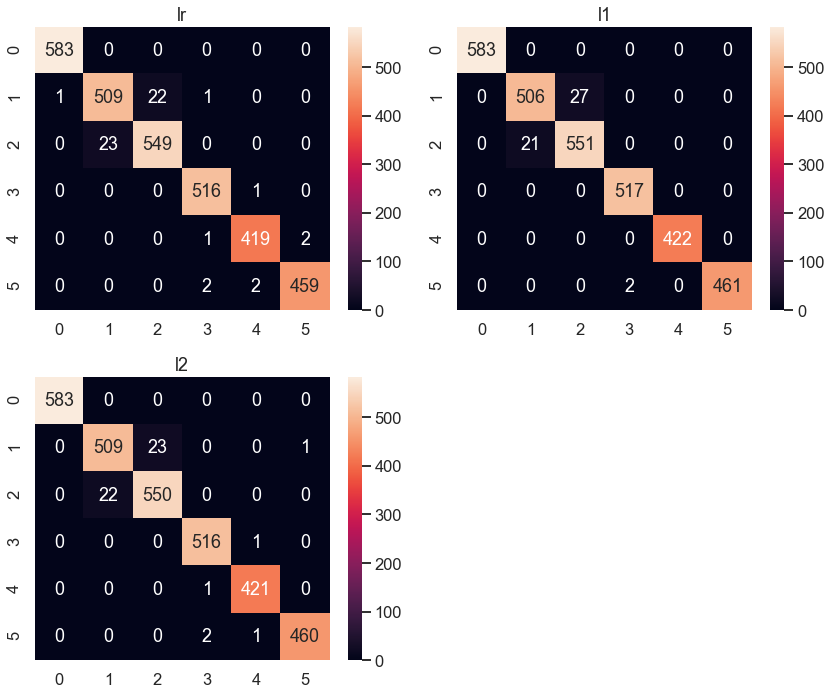

In [56]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [57]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
metrics

,lr,l1,l2
precision,0.982179,0.983835,0.983485
recall,0.982201,0.983819,0.983495
fscore,0.982188,0.983815,0.983488
accuracy,0.982201,0.983819,0.983495
auc,0.989214,0.990144,0.989983


In [63]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation
metrics_new

[precision    0.936765
 recall       0.936570
 fscore       0.936578
 accuracy     0.936570
 auc          0.961978
 Name: lr, dtype: float64,
 precision    0.937335
 recall       0.937217
 fscore       0.937229
 accuracy     0.937217
 auc          0.962271
 Name: l1, dtype: float64,
 precision    0.936978
 recall       0.936893
 fscore       0.936879
 accuracy     0.936893
 auc          0.962153
 Name: l2, dtype: float64]

Podemos observar uma queda da acuracia, gerada provavelmente pela pela a retirada de features do modelo